## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
np.random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

In [4]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df.query('(group == "treatment" & landing_page == "old_page") or (group == "control" & landing_page == "new_page")').shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().any()
#no rows have missing values

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.query('(group == "treatment" & landing_page == "new_page") or (group == "control" & landing_page == "old_page")')
df2.shape

(290585, 5)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
id = df2['user_id']

df2[id.isin(id[id.duplicated()])]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Repeated user_id is **773192**

c. What is the row information for the repeat **user_id**? 

**Row Numbers 1899 and 2893, 
treatment group, 
new_page, 
0**

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop([2892], inplace =True)

C:\Users\Maheen\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
df2.shape

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2[df2['group'] == "control"]['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2[df2['group'] == "treatment"]['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**The probability of an individual converting from the old page is 12% while the probability of an individual converting from the new page is 11.88%, which shows that there is a higher chance that the old page is more successful at converting the individuals to pay for the website's product. Although more rigourous testing might be required for conclusive decision-making, at this point it can be said that the old page leads to more conversions and there is no need to spend resources on developing a new page.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

   **Null Hypothesis: Our null hypothesis will be that the new page is as good or worse at converting users.**
   
   **Alternative Hypothesis: Our alternative hypothesis will be that the new page is better at converting users.**
   
  
   **Null Hypothesis: $p_{new}$ -  $p_{old}$  <=  0**


   **Alternative Hypothesis: $p_{new}$ - $p_{old}$ > 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

#under our null hypothesis p_new and p_old are equal

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2.query('landing_page == "new_page"').shape[0]

d. What is $n_{old}$?

In [22]:
n_old = df2.query('landing_page == "old_page"').shape[0]

In [23]:
p_new - p_old

0.0

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
#The new_page_converted follows a binomial distribution with 1 trial (i.e. one user accesing the website), 
#with a probability of p_new (i.e. the probability of converting when using the new page) 
#and a size of n_new(i.e. the number of times all users who land on the new page and convert).

np.random.seed(42)
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.11849150092904824

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
##The old_page_converted follows a binomial distribution with 1 trial (i.e. one user accesing the website), 
#with a probability of p_old (i.e. the probability of converting when using the old page) 
#and a size of n_old(i.e. the number of times all user who land on the old page and convert).

old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.12088880322700551

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [62]:
#This is the difference between the average probability of converting from the new page 
#and the average probability of converting from the old page; this will be our observed simulated difference



obs_diff= df2['converted'][df2['group'] == 'treatment'].mean() - df2['converted'][df2['group'] == 'control'].mean()
obs_diff

-0.0015782389853555567

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [55]:
p_new_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
p_old_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = p_new_simulation - p_old_simulation

p_new_simulation.mean(), p_old_simulation.mean()

(0.11958874199986237, 0.11958791800322151)

In [56]:
p_diffs = np.array(p_diffs)
p_diffs.mean()

8.239966408646604e-07

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

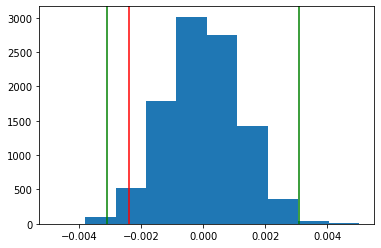

In [57]:
#using a 99% confidence interval, we get the following upper and lower bounds, which show where the majority values from our null
#lie

upper = np.percentile(p_diffs, 99.5)
lower = np.percentile(p_diffs, 0.5)

plt.hist(p_diffs)
plt.axvline(obs_diff, color = 'red') #observed difference
plt.axvline(upper, color = 'green') #upper bound
plt.axvline(lower, color = 'green'); #lower bound

**The histogram follows a normal distribution which is expected with a large enough sample according to the Central Limit Theorem.**


**At a 99% confidence interval, it can be seen that the observed statistic along with the majority of values lies within the range of values generated by our null hypothesis. This suggests that our observed statistic does come from our null hypothesis**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [58]:
null_vals = np.random.normal(0, p_diffs.std(), 10000)

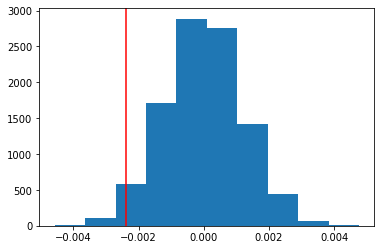

In [59]:
plt.hist(null_vals)
plt.axvline(obs_diff, color = 'red');

In [63]:
(p_diffs > obs_diff).mean()

0.9044

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Our alternative hypothesis suggested that the new page is better at converting users; since $p_{new}$ - $p_{old}$ > 0 
so we will check values to the right of our observed statistic (red line) which in this case comes out to be quite large, suggesting a high probability of our observed statistic coming from the null. In this case, we will fail to reject the null, which implies that the new page is the same or worse at converting users.** 

**We calculated the p-value above which checks if the observed result (difference) is statisically significant or not. It gives the probability of observing our statistic if the null is true. A small p-value (<= 0.05) indicates the probability of observing our statistic under the null is very small and suggests the alternative is true.A large p-value(>0.05) suggests there is not evidence against the null and we fail to reject it. Hence, in this case with a p-value of 0.9044, we do not have statistically significant evidence to reject the null and using the old page would be recommended in this case.**


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]
n_old

145274

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], value = None, alternative = 'smaller', prop_var = False)

In [35]:
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p-value is quite large, which suggests there is sufficient evidence for the null and we fail to reject it. This finding is consistent with our findings in the sections above.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**
Used when we have to predict one of two possible outcomes. 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
import statsmodels.api as sm

In [37]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [38]:
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])


C:\Users\Maheen\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [39]:
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])

In [40]:
df2.head()

,user_id,timestamp,group,landing_page,converted,new_page,old_page,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,0


In [41]:
df2['intercept'] =1

C:\Users\Maheen\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [42]:
log_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 07 Dec 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:13:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

**The logarithmic regression above shows a coefficient value of -0.0150 value for ab_page. For logistic interpretation we'll exponentiate the coefficient as below.**

In [43]:
1/np.exp(-.0150)

1.015113064615719

**This implies that with the ab_page (i.e. the treatment page) the likelihood of converting decreases by 1.015 times.** 

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value in part II is 0.90 and the p-value in part II is 0.190, the former comes from a one-sided test while the latter is from a two-sided test. The relationship between the two is 1-0.19/2 = 0.90. In both cases we cannot reject the null hypothesis.** 


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Based on the calculations above, it would be recommended for the company to not invest in developing a new page since there is no statistical evidence to prove that a new page would increase the likelihood of more conversions. It would be suggested to maintain the old page for now.**

**There could be other factors at play which could be added to the model to determine if the new page could be effective, however, consideration would have to be taken for these other factors to ensure there is no colinearity with our existing x variables.**


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [44]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [45]:
### Create the necessary dummy variables

df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.drop(['intercept'], axis = 1, inplace =True)
df_new

,country,timestamp,group,landing_page,converted,new_page,old_page,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,0,1,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,0,1,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,1,1,0,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,0,1,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
945994,UK,2017-01-03 14:41:21.565258,control,old_page,0,0,1,1,0,0,1,0
945996,US,2017-01-09 18:58:19.952277,treatment,new_page,0,1,0,0,1,0,0,1
945997,US,2017-01-04 06:56:24.658147,control,old_page,0,0,1,1,0,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
### Fit Your Linear Model And Obtain the Results

df_new['intercept']  = 1

nlm = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])

#dropping US dummy variable which will be our baseline for making comparisons across countries. 

In [47]:
results = nlm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 07 Dec 2020   Pseudo R-squ.:               1.521e-05
Time:                        15:13:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [48]:
1/np.exp(-0.0408), 1/np.exp(0.0099)

(1.0416437559600236, 0.9901488436829571)

**This shows that individuals in Canada are 1.041 times less likely to convert compared to the US
  and individuals in the UK are 0.99 times more likely to convert compared to the US.**
 

In [49]:
#using interaction terms of countries with ab_page

df_new['US_abpage'] = df_new['US']*df_new['ab_page']
df_new['UK_abpage'] = df_new['UK']*df_new['ab_page']
df_new['CA_abpage'] = df_new['CA']*df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,new_page,old_page,control,ab_page,CA,UK,US,intercept,US_abpage,UK_abpage,CA_abpage
user_id,,,,,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,0,1,0,0,1,1,1,0,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,0,1,0,0,1,1,1,0,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,1,1,0,0,0,1,1,0,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,0,1,0,0,1,1,1,0,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,0,1,0,0,1,1,1,0,0


In [50]:
#again dropping US-interaction dummy variable
nlm2 = sm.Logit(df_new['converted'], df_new[['intercept', 'UK_abpage', 'CA_abpage']])
results2 = nlm2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 07 Dec 2020   Pseudo R-squ.:               2.364e-05
Time:                        15:13:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -322.049      0.000      -2.008      -1.984
UK_abpage      0.0149      0.017      0.862      0.389      -0.019       0.049
CA_abpage     -0.0752      0.038     -1.997      0.046      -0.149      -0.001
==============================================================================
"""

In [51]:
1/np.exp(0.0149), 1/np.exp(-0.0752)

(0.9852104557227469, 1.0780997492739288)

**From the results it can be seen that users in the UK are 0.985 times more likely to convert when using the new page
while users in Canada are 1.078 times less likely to convert using the new page.**

**However the p-values for both these x-variables show the effect of each on conversion is not statisically significant, with all things held constant.**

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.